In [20]:
import sys
import os
os.environ['CLMM_MODELING_BACKEND'] = 'nc'
import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
from clmm import Cosmology
from clmm.support import mock_data as mock
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
import numpy as np
import pyccl as ccl
import numpy as np
import sys
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from scipy.integrate import quad,simps, dblquad

In [21]:
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling')
import miscentering as mis
import two_halo_term as twoh

In [22]:
from cluster_toolkit import miscentering
from cluster_toolkit import deltasigma

In [23]:
import cluster_toolkit as ct

In [53]:
logm = 14.4
cluster_m = 10**logm
cluster_z = 0.5
moo = clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'einasto')
mock_cosmo = Cosmology(H0=70.0, Omega_dm0=0.27-0.045, Omega_b0=0.045, Omega_k0=0.0)
cosmo_ccl = ccl.Cosmology(Omega_c=0.27-0.045, Omega_b=0.045, h=0.7, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)
deff = ccl.halos.massdef.MassDef(200, 'critical', c_m_relation=None)
conc = ccl.halos.concentration.ConcentrationDiemer15(mdef=deff)
concentration = conc._concentration(cosmo_ccl, 10**logm, 1/(1 + cluster_z))
moo.set_cosmo(mock_cosmo)
moo.set_mass(cluster_m) 
moo.set_concentration(concentration)

In [54]:
print('concentration = ' + str(concentration))

concentration = 4.226214305733157


### Compute Miscentering

In [55]:
R_real = np.logspace(np.log10(1), np.log10(10), 50)
R_Sigma = np.logspace(np.log10(0.0001), np.log10(20), 500)

In [56]:
Sigma_nfw_clmm = moo.eval_surface_density(R_Sigma, cluster_z) #Msun/Mpc^2 real

In [57]:
Rmis = 0.1
ds_mis_rayleigh =  mis.predict_sigma_excess_miscentering(Sigma_nfw_clmm, R_real, R_Sigma, Rmis, cluster_z, "rayleigh", moo)
ds_mis_gamma =  mis.predict_sigma_excess_miscentering(Sigma_nfw_clmm, R_real, R_Sigma, Rmis, cluster_z, "gamma", moo)

DS - S
DS - S


In [58]:
ds_mis = ds_mis_gamma

### Computing Power spectrum for 2h term

In [63]:
kk = np.logspace(-5,5 ,100000)

In [64]:
R = np.logspace(np.log10(1), np.log10(20), 50)

In [65]:
Pk = twoh.compute_Pk(kk, cluster_z, cosmo_ccl)

In [66]:
ds_unbaised = twoh.ds_two_halo_term_unbaised(R, cluster_z, cosmo_ccl, kk, Pk)
bais_200c = twoh.halo_bais(logm = np.log10(cluster_m), concentration = concentration, mdef = 'critical', Delta = 200, cluster_z = cluster_z, cosmo_ccl = cosmo_ccl)
bais_200m = twoh.halo_bais(logm = np.log10(cluster_m), concentration = concentration, mdef = 'matter', Delta = 200, cluster_z = cluster_z, cosmo_ccl = cosmo_ccl)

In [67]:
bais = bais_200c

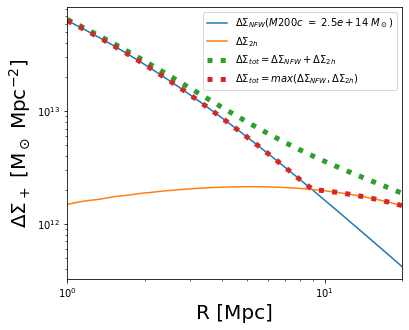

In [69]:
plt.figure(figsize = (6,5))
plt.loglog(R,moo.eval_excess_surface_density(R,cluster_z), '-', label = r'$\Delta\Sigma_{NFW}$' + f'$(M200c\ =\ {cluster_m:.1e}\ M_\odot)$')
#plt.loglog(R,ds_mis, '-', label = r'$\Delta\Sigma_{NFW, mis}$ ' + f'$(Rmis\ = {Rmis}\ Mpc)$')
plt.loglog(R,ds_unbaised*bais, '-', label = r'$\Delta\Sigma_{2h}$')
plt.plot(R, ds_unbaised*bais + 1*moo.eval_excess_surface_density(R, cluster_z),':',linewidth=5,label = r'$\Delta\Sigma_{tot} =\Delta\Sigma_{NFW} + \Delta\Sigma_{2h}$')
ds_tot_max = [max(ds_unbaised[i]*bais, 1*moo.eval_excess_surface_density(R[i], cluster_z)) for i in range(len(R))]
plt.plot(R, ds_tot_max,':',linewidth=5,label = r'$\Delta\Sigma_{tot} =max(\Delta\Sigma_{NFW},\Delta\Sigma_{2h})$')
plt.xlabel('R [Mpc]', fontsize = 20)
plt.ylabel(r'$\Delta\Sigma_+$ ' +'$[$' + r'${\rm M}$' + r'$_\odot\;$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$', fontsize = 20)
plt.legend(fontsize = 10)
plt.xlim(min(R),max(R))
plt.savefig('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/examples/modelingillustration', dpi = 300)